### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import windows

import sys
sys.path.append('../../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [ ]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

In [ ]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
class LSTM_Block(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_Block, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                                num_layers=num_layers, batch_first=True)

        self.gelu = nn.GELU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # 셀 상태를 0으로 초기화
    
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        # output = output.reshape(-1, self.hidden_size) # fc layer 적용을 위해 데이터를 1차원 형태로 조정
        out = self.gelu(output)

        return out
    
class simpleLSTM1d(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_size, hidden_size)

        self.net = nn.Sequential(*[
            LSTM_Block(hidden_size, hidden_size, 1)
            for i in range(num_layers)
        ])
        
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x): # B x T x 1
        x = self.gelu(self.dropout(self.fc1(x))) # x: B x T x 128
        x = self.net(x) # x: B x T x 128
        x = self.fc2(x) # x: B x T x 1 -> B x T
        x = self.gelu(x)

        return x

In [ ]:
# 모델 인스턴스 생성
input_size = 1  # 입력 크기
hidden_size = 128  # 임의의 hidden layer 크기
output_size = 1  # 출력 크기
num_layers = 2  # 임의의 LSTM layer 개수

model = simpleLSTM1d(input_size, hidden_size, output_size, num_layers).to(device)
print(model)

# 가중치 초기화 함수 정의
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)  # Xavier 초기화
        if m.bias is not None:
            m.bias.data.fill_(0.01)  # 편향 초기화

# 모델의 가중치 초기화 적용
model.apply(init_weights)

In [ ]:
# 손실 함수 정의 

class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

        # 학습 가능한 가중치 파라미터
        self.signal_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))
        self.fft_weight = nn.Parameter(torch.tensor(0.1, requires_grad=True))

    def forward(self, y_pred, y, y_pred_fft, y_fft):
        signal_loss = self.mse_loss(y_pred, y)
        fft_loss = self.mse_loss(y_pred_fft, y_fft)

        # 가중치 적용
        total_loss = self.alpha * (signal_loss * self.signal_weight) + \
                     (1 - self.alpha) * (fft_loss * self.fft_weight)

        return total_loss


In [19]:
# 손실 함수와 옵티마이저 정의
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 200

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T x 1
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)

        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 5/200, Loss: 0.0001430525881005451
Epoch 10/200, Loss: 8.743924990994856e-05
Epoch 15/200, Loss: 4.5139400754123926e-05
Epoch 20/200, Loss: 3.719692540471442e-05
Epoch 25/200, Loss: 3.0421399060287513e-05
Epoch 30/200, Loss: 6.804818258387968e-05
Epoch 35/200, Loss: 2.576377119112294e-05
Epoch 40/200, Loss: 2.4372919142479077e-05
Epoch 45/200, Loss: 2.4700060748727992e-05
Epoch 50/200, Loss: 2.268757816636935e-05
Epoch 55/200, Loss: 2.6291138055967167e-05
Epoch 60/200, Loss: 2.0892548491247e-05
Epoch 65/200, Loss: 2.162322743970435e-05
Epoch 70/200, Loss: 1.9614437405834906e-05
Epoch 75/200, Loss: 1.8855163943953812e-05
Epoch 80/200, Loss: 1.7703041521599516e-05
Epoch 85/200, Loss: 2.5024150090757757e-05
Epoch 90/200, Loss: 2.1050769646535628e-05
Epoch 95/200, Loss: 1.6700561900506727e-05
Epoch 100/200, Loss: 2.8263144486118108e-05
Epoch 105/200, Loss: 1.4560967429133598e-05
Epoch 110/200, Loss: 1.3807787581754383e-05
Epoch 115/200, Loss: 1.3124489669280592e-05
Epoch 120/200, Los

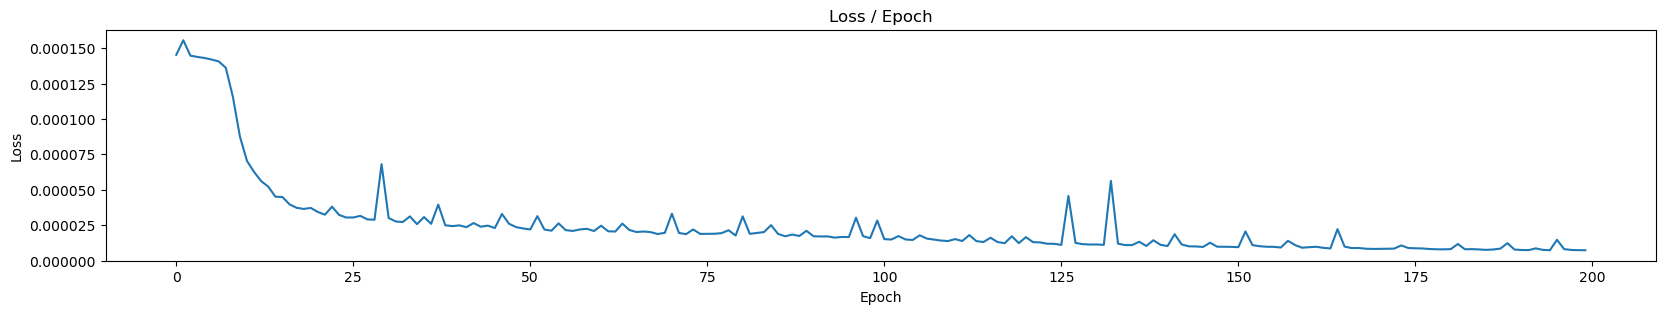

Minimal Loss: 7.332805125770392e-06 [199]



In [20]:
# Train Loss Plot
Loss_Plot(loss_list)

In [21]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len, _ = y.shape
        y = y.view(batch_size, seq_len, -1)
        y_pred = y_pred.view(batch_size, seq_len, -1)
        
        # Ensure y is a PyTorch tensor and detach it before converting to NumPy
        y_cpu = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else y
        y_pred_cpu = y_pred.detach().cpu().numpy()

        _, _, _, y_fft = FFT(y_cpu, fs=2000, single_sided=True)
        _, _, _, y_pred_fft = FFT(y_pred_cpu, fs=2000, single_sided=True)
    
        y_pred_fft = torch.tensor(y_pred_fft, dtype=torch.float32).to(y_pred.device)
        y_fft = torch.tensor(y_fft, dtype=torch.float32).to(y.device)

        # 배치 크기 불일치 처리
        if y_pred_fft.shape[0] != y_fft.shape[0]:
            min_batch_size = min(y_pred_fft.shape[0], y_fft.shape[0])
            y_pred_fft = y_pred_fft[:min_batch_size]
            y_fft = y_fft[:min_batch_size]

        if y_pred.shape[0] != y.shape[0]:
            min_batch_size = min(y_pred.shape[0], y.shape[0])
            y_pred = y_pred[:min_batch_size]
            y = y[:min_batch_size]

        loss = criterion(y_pred, y, y_pred_fft, y_fft)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        SACed_spectro = torch.cat((SACed_spectro, y_pred_fft.cpu()), 0)
        Clean_spectro = torch.cat((Clean_spectro, y_fft.cpu()), 0)

val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
print(f'Validation Loss: {val_loss.item()}')           

Validation Loss: 5.965255695628002e-06


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\stell\\UGRP_2024\\GitHub\\UGRP\\SAC_ANN\\result\\latest result_fig.png'

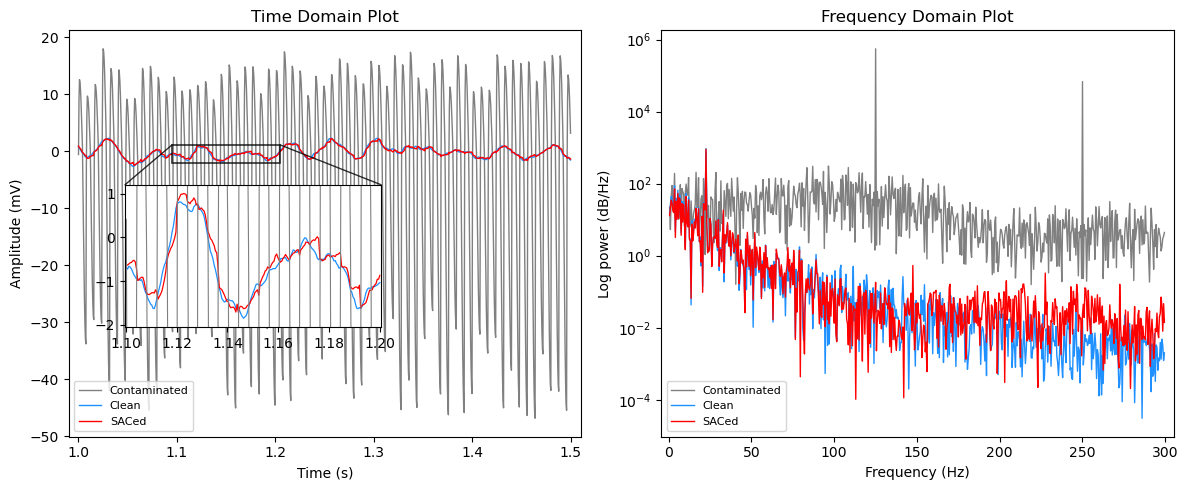

In [22]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

In [ ]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)